# Updated algorithm for determining LF ice edge

In [1]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from functions import trend, load_ice, plot_cartopy
from matplotlib import gridspec

# %matplotlib notebook

In [2]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]       

CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100


# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

## Code for obtaining coastline points

Method: Search for the first masked value in i direction (towards coastline). Because some rows start with masked indices before the ocean (unmasked), look for first masked index after an unmasked index.  

953


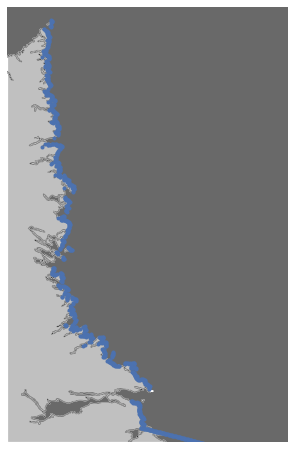

In [544]:
# Get coastline edge
m = np.shape(CT)[2]

coast_i = np.zeros((m))
coast_j = np.zeros((m))

for i in range(m):
    if ma_lon[:,i].count() !=0:
        # Get indef of the first masked value in row i
        first_unmasked = np.where(ma_lon.mask[:,i] == False)[0][0]
        # Array of masked indices in row i
        masked_indices = np.where(ma_lon.mask[:,i] == True)[0]
        # Most eastward point of the coastline in row i
        first_land = masked_indices[np.where(masked_indices > first_unmasked)][0]
        coast_i[i] = i
        coast_j[i] = first_land
        
    else:
        print(i)
        
coast_i = coast_i.astype(int)
coast_j = coast_j.astype(int)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
# plt.plot(lon[coast_j[50:-200],coast_i[50:-200]],lat[coast_j[50:-200],coast_i[50:-200]],'.-',transform=ccrs.PlateCarree(),zorder=4)
plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'.',transform=ccrs.PlateCarree(),zorder=4)


There is some interpolation using allsegs. However, I think this is OK (at least for now) because 1) the coastline is constant (AKA the reference points when calculating Sina distance will not change between years) and 2) The resolution of our data is fine enough where the interpolation is pretty good. 

## Code for obtaining Sina points

In [535]:
### Updated algorithm for finding Sina

# Which month?
mon = 4

m = np.shape(CT)[2]
n = np.shape(CT)[1]

ind_i = np.zeros((m))
ind_j = np.zeros((m))

IND_I = []
IND_J = []

# Mask lon and lat to get land               
ma_lon = ma.masked_array(lon, mask=land)
ma_lat = ma.masked_array(lat, mask=land)


for yr in years_unique:
#     Every year for the month defined by mon
    which = (years == yr) * (np.array(months) == mon)
    ind_i = np.zeros((m))
    ind_j = np.zeros((m))
    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]

    for i in range(m):
        for j in range(n):
            # Is there landfast ice in row i? 
            if 100.0 in CT[tt,:,i]:
                ind_i[i] = i
                # jth index is the outermost point of LF ice for row i
                ind_j[i] = np.where(CT[tt,:,i]==100.0)[0][0]
                break
            # Fill missing LF rows with coastline coordinates
            elif 100.0 not in CT[tt,:,i]:
                if ma_lon[:,i].count() !=0: 
                    ind_i[i] = i
#                     ind_j[i] = ma.notmasked_edges(ma_lon[:,i])[1]
                    ind_j[i] = coast_j[i]
                    break
                else:
                    # If array is completely masked (it's all land), save index as false and deal with it later
                    ind_i[i] = i
                    ind_j[i] = False
                    break

    ind_i = ind_i.astype(int)
    ind_j = ind_j.astype(int)
    
    IND_I.append(ind_i)
    IND_J.append(ind_j)

Visualize: Plot Sina of March (first index)

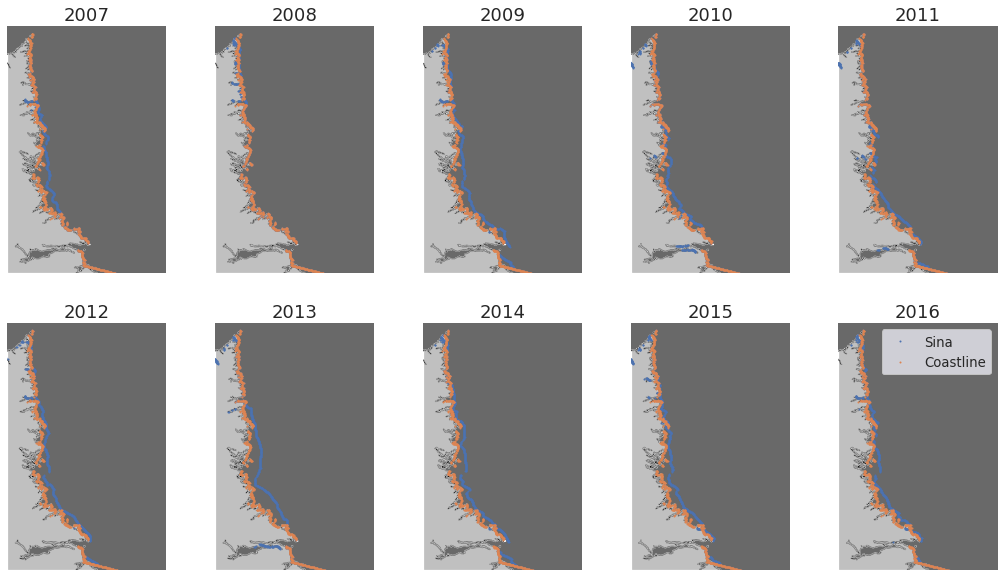

In [543]:
fig = plt.figure(figsize=(18,10))
# plt.pcolormesh(lon,lat,CT[tt,:,:],cmap='Blues_r')

cnt = 1
# Just plot some years
for i in range(10,20):   
    ax = fig.add_subplot(2,5,cnt, projection=rot)
    plot_cartopy(ax,lon,lat)
    plt.plot(lon[IND_J[i],IND_I[i]],lat[IND_J[i],IND_I[i]],'.', markersize=2, transform=ccrs.PlateCarree(),zorder=4, label='Sina')
    plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'.',markersize=2,transform=ccrs.PlateCarree(),zorder=4, label='Coastline')
    plt.title(years_unique[i],fontsize=18)
    cnt+=1

plt.legend()

### Calculate distances between Sina and coastline

In [537]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

Text(0.5, 1.0, 'Location of time series')

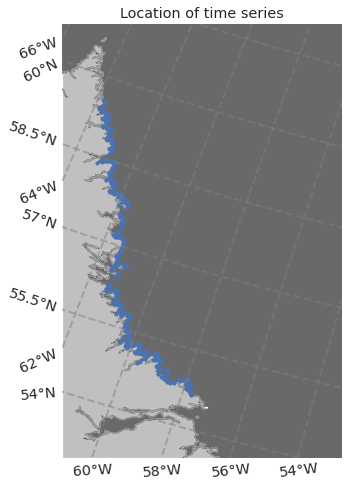

In [538]:
m = len(years_unique)
n = len(coast_j)
D_KM = np.zeros((m,n))

for yr in range(len(D_KM)):

    u_km, v_km = deg2km(lat[coast_j,coast_i], lon[IND_J[yr],IND_I[yr]]-lon[coast_j,coast_i])
#     d_km.append(u_km)
    D_KM[yr,:] = u_km


### Calculate trends
Nbound = 150
Sbound = -200
# Reduce domain (see map below)
d_km = D_KM[:,Nbound:Sbound]
ytrend = np.zeros(np.shape(d_km)[1])
#     dtrend_95=np.zeros(np.shape(d_km)[1])
#     ybar=np.zeros(np.shape(d_km)[1])

for i in range(np.shape(d_km)[1]):
    mean, tr, dt95 = trend(np.array(years_unique),d_km[:,i])
    ytrend[i] = tr
#         dtrend_95[i] = dt95
#         ybar[i] = mean


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
 
# Indices of N and S bounds

plt.plot(lon[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]],lat[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]],'.-',transform=ccrs.PlateCarree(),zorder=4)

# Add gridlines
sns.set(font_scale=1.2)
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False
plt.title('Location of time series')


### Plot Heatmap
 (with new reduced domain)

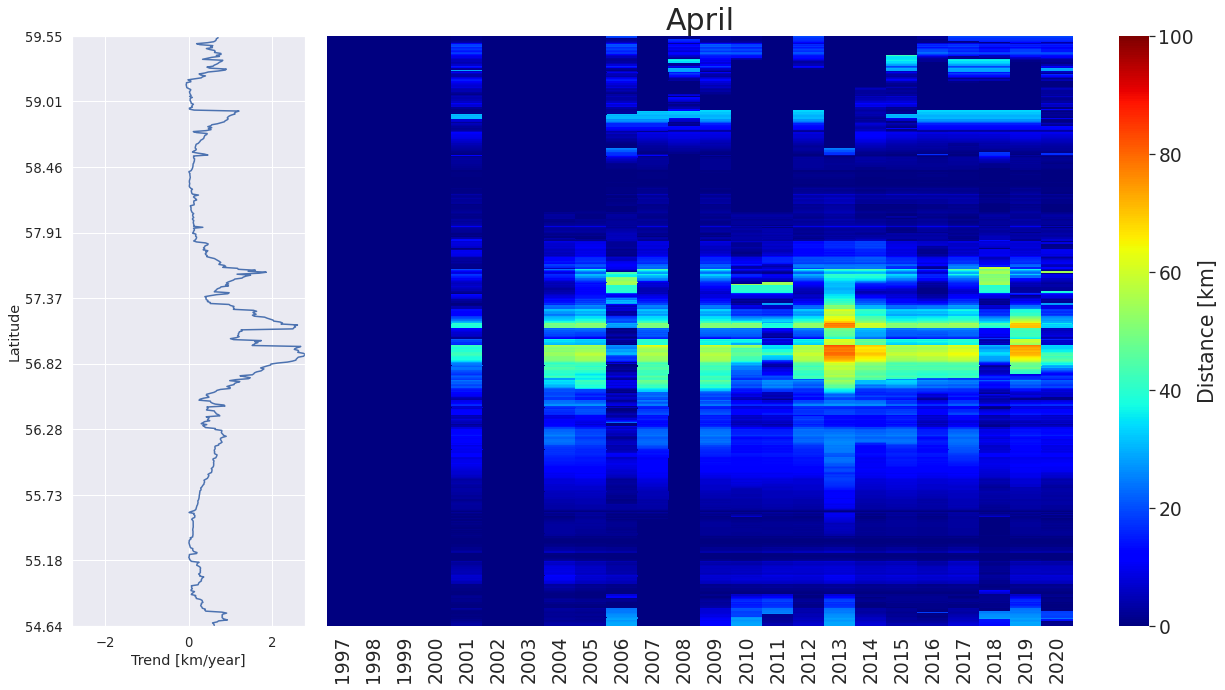

In [539]:
# Heatmap
fig = plt.figure(figsize=(18,10))
# Alter width ratios of subplots for trend plotting
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4]) 
ax = fig.add_subplot(gs[0])

# New domain
coastlon = lon[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]]
coastlat = lat[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]]

# Plot trends
sns.set(font_scale=1.7)
# Plot reverse so latitude decreases from top to bottom
plt.plot(ytrend[::-1],np.arange(0,len(ytrend)))
# Label from high to low lat
ytick_labels = np.round(np.linspace(coastlat[0],coastlat[-1],10),2)
plt.yticks(np.linspace(d_km.shape[1],0,10), ytick_labels)  # Set text labels and properties.
plt.xlabel('Trend [km/year]')
plt.ylabel('Latitude')
plt.ylim([0,d_km.shape[1]])
# Normalize x axis
plt.xlim([-1*np.max(abs(ytrend)),np.max(abs(ytrend))])

# Plot heatmap
ax = fig.add_subplot(gs[1])

# Flip it so y axis increases with latitude
d_km_arr = np.array(d_km)
# Plot heatmap of distance
ax = sns.heatmap(d_km_arr.transpose(), cmap='jet', cbar_kws={'label': 'Distance [km]'}, vmin=0, vmax=100)
# ax.invert_yaxis()
ax.set_yticks(np.linspace(d_km_arr.shape[1],0,10))
# ax.set_yticklabels(ytick_labels)
xtick_labels = years_unique
ax.set_xticklabels(xtick_labels,rotation='vertical')

# Only call set font scale once. to undo, call sns.reset_defaults()
# sns.set(font_scale=1.4)

cbar = ax.collections[0].colorbar
mon_str = ['January','February','March','April','May']
plt.title(mon_str[mon-1],fontsize=30)
plt.tight_layout()
# plt.savefig('/home/mwang/CIS-project/figures/May5_LF_May_heatmap+trend_manfilt')


Text(0.5, 1.0, 'd_km anomolies (km)')

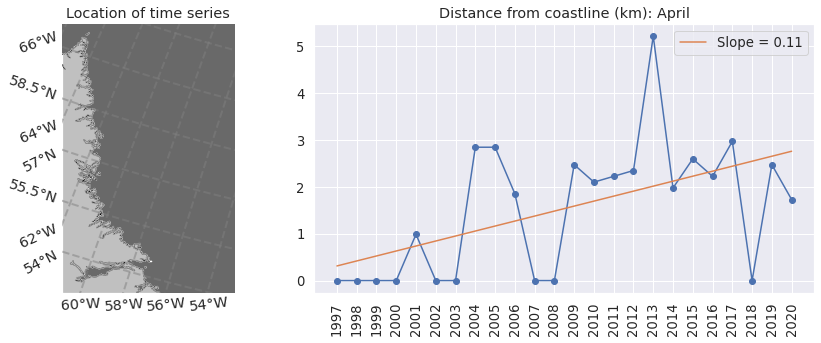

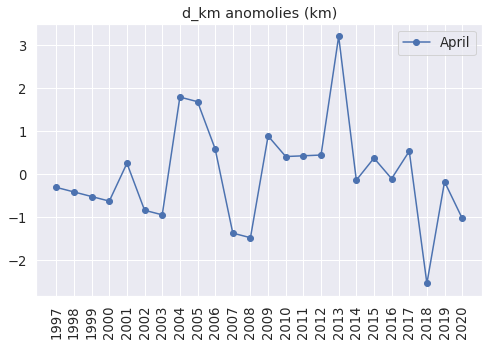

In [541]:
# sns.reset_defaults()
sns.set(font_scale=1.2)

# Location on map
tt = 500
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
# ax = fig.add_subplot(1,2,1, projection=rot)
ax = fig.add_subplot(gs[0], projection=rot)
plot_cartopy(ax,lon,lat)
# Add gridlines
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False
plt.title('Location of time series')

# Plot distance and trendline

ax = fig.add_subplot(gs[1])
plt.plot(d_km[:,tt],'o-')
s,b = np.polyfit(years_unique,d_km[:,tt],1)
plt.plot(ytrend[tt]*np.array(years_unique) + b, label=f"Slope = {np.round(s,2)}")
plt.title('Distance from coastline (km): ' + mon_str[mon-1] )
# Fix x tick labels
plt.xticks(np.arange(0, len(d_km), 1.0))
xtick_labels = years_unique
ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.tight_layout()
plt.legend()

# Subtract trend from mean to get anomolies

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
# Get b 
s,b = np.polyfit(years_unique,d_km[:,tt],1)
anom = d_km[:,tt] - (np.array(years_unique)*ytrend[tt] + b) 
plt.plot(anom,'o-', label=mon_str[mon-1])
plt.xticks(np.arange(0, len(d_km), 1.0))
xtick_labels = years_unique
ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.legend()
plt.title('d_km anomolies (km)')